# Recurent Neural Network (RNN)

Recurrent Neural Network (RNN) is a special type of artificial neural network adapted to work for time series data or data that involves sequences. Ordinary feedforward neural networks are only meant for data points that are independent of each other. However, if we have data in a sequence such that one data point depends upon the previous data point, we need to modify the neural network to incorporate the dependencies between these data points. RNNs have the concept of “memory” that helps them store the states or information of previous inputs to generate the next output of the sequence.

![image](https://miro.medium.com/v2/resize:fit:720/format:webp/1*88v6lf17GqXSIPnQNA5ktQ.png)

## Load Libraries and Dataset

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
import re

In [2]:
# Load dataset from database

db = sqlite3.connect('C:/Users/ASUS/Documents/Platinum Challenge/database.db', check_same_thread = False)
q_data = 'SELECT * FROM data'
data = pd.read_sql_query(q_data, db)
data.head()

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai ap...,neutral
2,lokasi strategis di jalan sumatra bandung temp...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,aduh jadi mahasiswa jangan sombong dong kasih ...,negative


In [3]:
# Data distribution check

data['Label'].value_counts()

positive    6383
negative    3412
neutral     1138
Name: Label, dtype: int64

## Feature-Label Classification

In [4]:
# Group data tweet

pos_tweet = data.loc[data['Label']=='positive'].Tweet.tolist()
neg_tweet = data.loc[data['Label']=='negative'].Tweet.tolist()
neu_tweet = data.loc[data['Label']=='neutral'].Tweet.tolist()

# Group data label

pos_label = data.loc[data['Label']=='positive'].Label.tolist()
neg_label = data.loc[data['Label']=='negative'].Label.tolist()
neu_label = data.loc[data['Label']=='neutral'].Label.tolist()

In [5]:
# Final sentiment data check

total_data = pos_tweet + neg_tweet + neu_tweet
labels = pos_label + neu_label + neg_label

print("Positive: %s, Negative: %s, Neutral: %s" % (len(pos_tweet), len(neu_tweet), len(neg_tweet)))
print("Total data: %s" % len(total_data))
print("Total labels: %s" % len(labels))

Positive: 6383, Negative: 1138, Neutral: 3412
Total data: 10933
Total labels: 10933


## Feature Extraction

Now we will perform feature extraction. The feature extraction that we do is the tokenizer (converts text into a sequence of integers or into a vector) and pad sequence (converts a list of sequences into a 2D vector/array). The feature extraction results will be stored with the help of the pickle library.

In [6]:
# Tokenizer and pad sequence

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [7]:
# Feature extraction for labels

Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


## Train-Test Data Split

Now we prepare a train and test dataset with split train and test data for training and testing the dataset.

In [8]:
# Split train-test data with proportion 80:20

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model Training

Next, we'll do model training using the RNN algorithm. Then we also do cross validation 5 times to check performance stability.

In [9]:
# Model training and cross validation

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    
    # Create model architecture

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(SimpleRNN(units, dropout=0.8))
    model.add(Dense(3,activation='softmax'))
    # model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.0005)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                        validation_data=(X_test, y_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", round(average_accuracy,4))

Epoch 1/50
274/274 [==============================] - 60s 211ms/step - loss: 0.7219 - accuracy: 0.7114 - val_loss: 0.5964 - val_accuracy: 0.7700
Epoch 2/50
274/274 [==============================] - 50s 183ms/step - loss: 0.5316 - accuracy: 0.7954 - val_loss: 0.5367 - val_accuracy: 0.7910
Epoch 3/50
274/274 [==============================] - 61s 223ms/step - loss: 0.4591 - accuracy: 0.8189 - val_loss: 0.5365 - val_accuracy: 0.7984
Epoch 4/50
274/274 [==============================] - 66s 242ms/step - loss: 0.3972 - accuracy: 0.8403 - val_loss: 0.5113 - val_accuracy: 0.8048
Epoch 5/50
274/274 [==============================] - 65s 239ms/step - loss: 0.3580 - accuracy: 0.8576 - val_loss: 0.5543 - val_accuracy: 0.7846
Epoch 6/50
274/274 [==============================] - 60s 219ms/step - loss: 0.3043 - accuracy: 0.8820 - val_loss: 0.5498 - val_accuracy: 0.7929
Epoch 6: early stopping
69/69 [==============================] - 1s 6ms/step
Training ke- 1
              precision    recall  f1-

## Evaluation

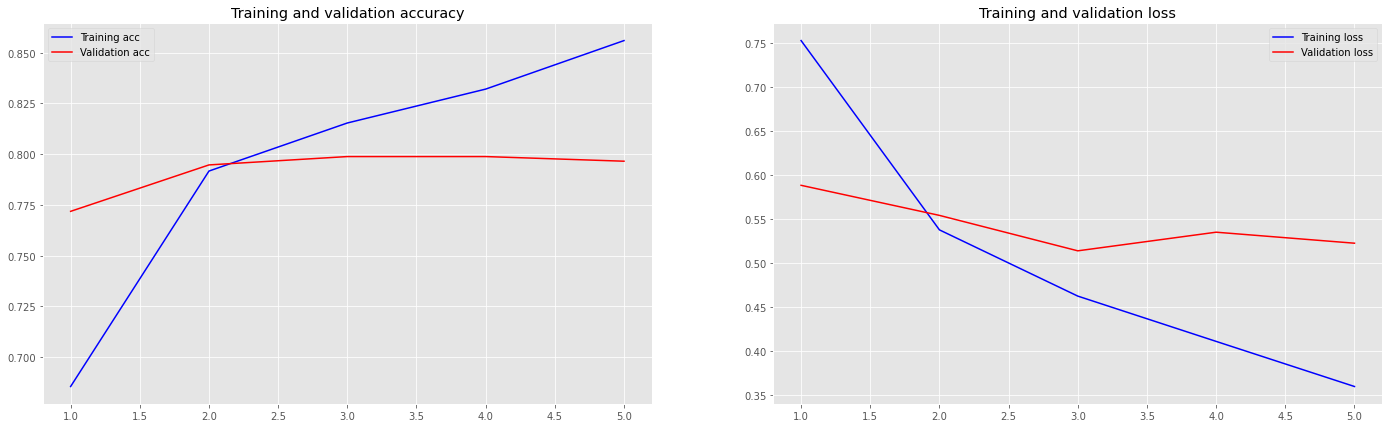

In [10]:
# Visualize it

plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

- With 5 times cross validation, the model performance is stable at 79.22% accuracy
- It can be seen that the performance with minimal loss occurred in the second epoch
- Majority model training stopped after fifth epoch

In [11]:
# Save the model

model.save('model.h5')
print("Model has created!")

Model has created!


## Prediction

In [12]:
input_text = """
Makanannya enak  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 238ms/step
Text:  makanannya enak  
Sentiment: positive


In [13]:
input_text = """
Normal saja  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 295ms/step
Text:  normal saja  
Sentiment: negative
